# Weather Prediction Bern 

# 1 First steps

In [87]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler # same as standardscaler, difference: handles outliers better than StandardScaler
import seaborn as sns
from scipy import stats # for box-cox
from scipy.stats import skew # to test skew
# Libraries below for model training and evaluation
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_absolute_error
# for model comparison 
from IPython.display import display, Markdown

In [3]:
# EDA in earlier notebooks

In [4]:
# import data 
df = pd.read_csv("/home/ephraim/UNIGE/Classes/01 ML Machine Learning /ML Project/Weather Data-20251104/train.csv")


# Make a copy of the dataset
df_copy = df.copy()

# Drop the column named 'index' if it exists
df_copy = df_copy.drop(columns=['index'], errors='ignore')

# Drop rows with missing values
df_copy = df_copy.dropna()


### 1.1 Correlation between feature variables

In [5]:
# get all station columns in single variable
fkl0_cols = [col for col in df_copy.columns if col.startswith("fkl010h0")] # wind speed
fkl3_cols = [col for col in df_copy.columns if col.startswith("fkl010h3")] # gust peak
gre_cols = [col for col in df_copy.columns if col.startswith("gre000h0")] # global radiation
pp0q_cols = [col for col in df_copy.columns if col.startswith("pp0qffh0")] # pressure reduced to sea level
pres_cols = [col for col in df_copy.columns if col.startswith("prestah0")] # pressure at altitude
rre_cols = [col for col in df_copy.columns if col.startswith("rre150h0")] # precipitation
sre_cols = [col for col in df_copy.columns if col.startswith("sre000h0")] # sunshine duration
tre_cols = [col for col in df_copy.columns if col.startswith("tre200h0")] # current air temperature
temp_cols = [col for col in df_copy.columns if col.startswith("tre")] # temperature 
ure_cols = [col for col in df_copy.columns if col.startswith("ure200h0")] # humidity
target_cols = ['target_tre200h0_plus12h', 'target_tre200h0_plus24h', 'target_tre200h0_plus48h'] # targets

# all feature colums in one variable
all_cols = [
    fkl0_cols,  # wind speed
    fkl3_cols,  # gust peak
    gre_cols,   # global radiation
    pp0q_cols,  # pressure reduced to sea level
    pres_cols,  # pressure at altitude
    rre_cols,   # precipitation
    sre_cols,   # sunshine duration
    tre_cols,   # current air temperature
    temp_cols,  # temperature (general 'tre' prefix)
    ure_cols    # humidity
]

print(f" fkl0_cols correlation: {df_copy[fkl0_cols].corr().mean().mean()}") 
print(f" fkl3_cols correlation: {df_copy[fkl3_cols].corr().mean().mean()}") 
print(f" gre_cols correlation: {df_copy[gre_cols].corr().mean().mean()}") 
print(f" pp0q_cols correlation: {df_copy[pp0q_cols].corr().mean().mean()}") 
print(f" pres_cols correlation: {df_copy[pres_cols].corr().mean().mean()}") 
print(f" rre_cols correlation: {df_copy[rre_cols].corr().mean().mean()}") # the correlation is very small -> only 0.26 so we will not take the mean of these columns
print(f" sre_cols correlation: {df_copy[sre_cols].corr().mean().mean()}") 
print(f" tre_cols correlation: {df_copy[tre_cols].corr().mean().mean()}") 
print(f" ure_cols correlation: {df_copy[ure_cols].corr().mean().mean()}") 
print(f" target_cols correlation: {df_copy[target_cols].corr().mean().mean()}") 

 fkl0_cols correlation: 0.335559994744861
 fkl3_cols correlation: 0.39958916953518314
 gre_cols correlation: 0.8998473791328815
 pp0q_cols correlation: 0.9404038488066361
 pres_cols correlation: 0.9244353623457021
 rre_cols correlation: 0.26972178039711003
 sre_cols correlation: 0.7237841913789683
 tre_cols correlation: 0.9242098087728811
 ure_cols correlation: 0.5602063620113834
 target_cols correlation: 0.8505259951031029


### 1.2 Correlation between current and target temperatures 

In [6]:
# 2. Calculate the correlation matrix for the relevant columns
# Note: You only need to pass the list of all columns involved.
corr_matrix = df_copy[tre_cols + target_cols].corr()

# 3. Extract the sub-matrix of 'current vs target' correlations
# Rows = current temperatures (tre_cols), Columns = future targets (target_cols)
current_to_target_corr = corr_matrix.loc[tre_cols, target_cols]

# 4. Find the strongest correlated current temperature for each target
# Use .idxmax() on the absolute values of the correlations
most_correlated = current_to_target_corr.abs().idxmax()

# 5. Display the results
print("### 🌡️ Current Stations Most Correlated with Future Targets ###")
print(most_correlated)

# Optional: Display the corresponding correlation value
print("\n### 📈 Corresponding Maximum Correlation Values (Magnitude) ###")
print(current_to_target_corr.abs().max())

### 🌡️ Current Stations Most Correlated with Future Targets ###
target_tre200h0_plus12h    tre200h0_STG
target_tre200h0_plus24h        tre200h0
target_tre200h0_plus48h    tre200h0_SIO
dtype: object

### 📈 Corresponding Maximum Correlation Values (Magnitude) ###
target_tre200h0_plus12h    0.791973
target_tre200h0_plus24h    0.930155
target_tre200h0_plus48h    0.889016
dtype: float64


# 2 Preprocessing

### 2.1 Precipitation - RRE columns

In [7]:
# correlation
print(f" rre_cols correlation: {df_copy[rre_cols].corr().mean().mean()}") # the correlation is very small -> only 0.26 so we will not take the mean of these columns

 rre_cols correlation: 0.26972178039711003


In [8]:
# rre columns - transform without grouping over stations
# 1 Cap each rre column at 1% and 99%


for col in rre_cols:
    lower = df_copy[col].quantile(0.01)
    upper = df_copy[col].quantile(0.99)
    df_copy[col] = np.clip(df_copy[col], lower, upper)

# 2 Apply box-cox transfo to all rre variables

epsilon = 1e-6 # shift
for col in rre_cols:
    data = df_copy[col]
    if (data <= 0).any(): # shift data if necessary for transfo
        shifted_data = data + epsilon
    else:
        shifted_data = data

    transformed_data, lmbda = stats.boxcox(shifted_data) # apply box-cox

    df_copy[col] = transformed_data

# Alternative for box-cox code
# df_copy[rre_cols] = stats.boxcox(df_copy[rre_cols] + 1e-6)




In [9]:
df_copy[rre_cols].head()

,rre150h0_ANT,rre150h0_BAS,rre150h0_DAV,rre150h0_DOL,rre150h0_GVE,rre150h0_INT,rre150h0_LUG,rre150h0_SIO,rre150h0_STG,rre150h0_ZER
0,-2527.771363,-61807.832452,-4456.835455,-1.555052,-35705.72206,-7227.328808,-39209.592247,-827293.410581,-2435.996107,-114826.43889
1,-2527.771363,-61807.832452,-4456.835455,-688.058935,-35705.72206,-7227.328808,-39209.592247,-827293.410581,-2435.996107,-114826.43889
2,-2527.771363,-61807.832452,-4456.835455,-688.058935,-35705.72206,-7227.328808,-39209.592247,-827293.410581,-2435.996107,-114826.43889
3,-2527.771363,-61807.832452,-4456.835455,-688.058935,-35705.72206,-7227.328808,-39209.592247,-827293.410581,-2435.996107,-114826.43889
4,-2527.771363,-61807.832452,-4456.835455,-688.058935,-35705.72206,-7227.328808,-39209.592247,-827293.410581,-2435.996107,-114826.43889


In [10]:
df_copy[rre_cols].max() # should be lower, why not working? --> Jarod

rre150h0_ANT    0.728958
rre150h0_BAS    0.535330
rre150h0_DAV    0.737669
rre150h0_DOL    1.044093
rre150h0_GVE    0.622518
rre150h0_INT    0.801761
rre150h0_LUG    0.879594
rre150h0_SIO    0.446195
rre150h0_STG    0.838288
rre150h0_ZER    0.465157
dtype: float64

In [11]:
# # sre - box-cox transformation for sre 
# epsilon = 1e-6 # shift
# for col in rre_cols:
#     data = df_copy[col]
#     if (data <= 0).any(): # shift data if necessary for transfo
#         shifted_data = data + epsilon
#     else:
#         shifted_data = data

#     transformed_data, lmbda = stats.boxcox(shifted_data) # apply box-cox

#     df_copy[col] = transformed_data

### 2.2 Sunshine Duration - SRE Columns 

In [12]:
df_copy[sre_cols].corr().mean().mean() # correlation high --> take mean and std

np.float64(0.7237841913789683)

In [13]:
# Step 1: Compute mean and std of all SRE columns
df_copy["sre000h0_mean"] = df_copy[sre_cols].mean(axis=1)
df_copy["sre000h0_std"]  = df_copy[sre_cols].std(axis=1)

sre_agg_cols = ['sre000h0_mean', 'sre000h0_std']
# check skew: df_copy["sre000h0_mean"].skew()

# 2 Apply box-cox transfo to all rre variables

epsilon = 1e-6 # shift
for col in sre_agg_cols:
    data = df_copy[col]
    if (data <= 0).any(): # shift data if necessary for transfo
        shifted_data = data + epsilon
    else:
        shifted_data = data

    transformed_data, lmbda = stats.boxcox(shifted_data) # apply box-cox

    df_copy[col] = transformed_data

df_copy = df_copy.drop(columns = sre_cols)


### 2.3 Global Radiation - GRE Columns

In [14]:
df_copy[gre_cols].corr().mean().mean() # correlation high --> take mean and std

np.float64(0.8998473791328815)

In [15]:
df_copy.shape

(7429, 84)

In [16]:
# Step 1: Compute mean and std of all SRE columns
df_copy["gre000h0_mean"] = df_copy[gre_cols].mean(axis=1)
df_copy["gre000h0_std"]  = df_copy[gre_cols].std(axis=1)

gre_agg_cols = ['gre000h0_mean', 'gre000h0_std']
# check skew: df_copy["sre000h0_mean"].skew()

# 2 Apply box-cox transfo to all rre variables

epsilon = 1e-6 # shift
for col in gre_agg_cols:
    data = df_copy[col]
    if (data <= 0).any(): # shift data if necessary for transfo
        shifted_data = data + epsilon
    else:
        shifted_data = data

    transformed_data, lmbda = stats.boxcox(shifted_data) # apply box-cox

    df_copy[col] = transformed_data

df_copy = df_copy.drop(columns = gre_cols)

In [17]:
df_copy.shape

(7429, 76)

### 2.4 Wind Speed and Gust Peak - FKL Columns

In [18]:
fkl_cols = fkl0_cols + fkl3_cols 

# 1 Cap each rre column at 1% and 99%

for col in fkl_cols:
    lower = df_copy[col].quantile(0.01)
    upper = df_copy[col].quantile(0.99)
    df_copy[col] = np.clip(df_copy[col], lower, upper)

# 2 Apply box-cox transfo to all rre variables

epsilon = 1e-6 # shift
for col in fkl_cols:
    data = df_copy[col]
    if (data <= 0).any(): # shift data if necessary for transfo
        shifted_data = data + epsilon
    else:
        shifted_data = data

    transformed_data, lmbda = stats.boxcox(shifted_data) # apply box-cox

    df_copy[col] = transformed_data


### 2.5 Season Column 

In [19]:
# transform
df_copy = pd.get_dummies(df_copy, columns = ['season'], prefix = 'season', drop_first = True)
season_cols = [col for col in df_copy if col.startswith('season')]
df_copy[season_cols] = df_copy[season_cols].astype(int)

### 2.6 Hour Column

In [20]:
# The cycle length is 24 hours (0 to 23)
max_hour = 24

# Calculate the sine and cosine components for the 'hour' feature
df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / max_hour)
df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / max_hour)

# drop the original hour column
df_copy = df_copy.drop(columns = ['hour'])

### 2.7 Temperature - TRE Colums 

In [21]:
df_copy[tre_cols].corr().mean().mean() # high correlation

np.float64(0.9242098087728811)

In [22]:
print([col for col in tre_cols if col.startswith("tre200h0")])

['tre200h0_ANT', 'tre200h0_BAS', 'tre200h0_DAV', 'tre200h0_DOL', 'tre200h0_GVE', 'tre200h0_INT', 'tre200h0_LUG', 'tre200h0_SIO', 'tre200h0_STG', 'tre200h0_ZER', 'tre200h0', 'tre200h0_lag24h']


In [23]:
df_copy.head()

,fkl010h0_ANT,fkl010h0_BAS,fkl010h0_DAV,fkl010h0_DOL,fkl010h0_GVE,fkl010h0_INT,fkl010h0_LUG,fkl010h0_SIO,fkl010h0_STG,fkl010h0_ZER,...,target_tre200h0_plus48h,sre000h0_mean,sre000h0_std,gre000h0_mean,gre000h0_std,season_Spring,season_Summer,season_Winter,hour_sin,hour_cos
0,0.265180,0.741806,-0.216893,3.025330,0.000000,-0.494584,-0.531221,-0.752548,1.402123,-0.107025,...,10.0,0.779607,1.529082,3.731901,2.883110,1,0,0,0.965926,0.258819
1,1.410065,-0.223155,1.591340,4.144879,1.722051,-0.663469,0.982872,-0.542621,0.748129,0.539382,...,6.3,-16.954279,-18.543150,-0.358873,0.398680,1,0,0,0.707107,0.707107
2,0.095680,0.693033,-1.739994,3.505744,0.709550,0.266791,0.094622,0.498997,-0.104162,0.093975,...,-2.1,-16.954279,-18.543150,-0.358873,0.398680,0,0,1,0.000000,1.000000
3,-0.221134,1.131098,0.634287,3.361009,0.000000,0.668783,-0.226978,-0.229074,-0.643424,-0.230697,...,6.5,3.071057,3.040139,4.988508,3.899557,0,0,0,-0.258819,-0.965926
4,1.574435,0.469951,1.768064,1.268408,0.751949,1.100084,1.605095,1.393340,0.000000,0.887201,...,23.9,3.310244,2.852780,5.831115,4.853880,0,1,0,0.258819,-0.965926


In [24]:
# reduce amount of features by taking mean and std of highly correlated features
df_copy["tre200h0_mean"] = df_copy[tre_cols].mean(axis=1)
df_copy["tre200h0_std"] = df_copy[tre_cols].std(axis=1)


cols_to_drop = [col for col in tre_cols if col not in ["tre200h0_STG", "tre200h0_INT", 'tre200h0', 'tre200h0_lag24h']]
df_copy = df_copy.drop(columns=cols_to_drop)
# Verify remaining temperature-related columns
print("Remaining temperature-related columns:",
      [col for col in df_copy.columns if "tre200h0" in col])


Remaining temperature-related columns: ['tre200h0_INT', 'tre200h0_STG', 'tre200h0', 'tre200h0_lag24h', 'target_tre200h0_plus12h', 'target_tre200h0_plus24h', 'target_tre200h0_plus48h', 'tre200h0_mean', 'tre200h0_std']


### 2.8 Feature Engineering

#### 2.8.1 Net Solar Heating Efficiency

The amount of global radiation ($\text{gre000h0}$) absorbed by the atmosphere and surface depends on the time of day and the existing air temperature

In [25]:
df_copy.shape

(7429, 73)

In [26]:
df_copy['Rad_X_HourCos'] = df_copy['gre000h0_mean'] * df_copy['hour_cos']
df_copy = df_copy.drop(columns = ['gre000h0_mean'])
df_copy.shape

(7429, 73)

#### 2.8.2 Gust Factor (Atmospheric Stability)

The Gust Factor (1$\text{GF}$) models atmospheric instability by comparing the peak gust (2$\text{fkl010h3}$) to the mean wind speed (3$\text{fkl010h0}$).4 Since wind is a vector, it's best to calculate this at a few representative stations.

In [27]:
# Identify all stations with fkl010 wind data
# We'll use the station codes that appear in both fkl010h0 and fkl010h3
wind_stations = [
    'ANT', 'BAS', 'DAV', 'DOL', 'GVE', 
    'INT', 'LUG', 'SIO', 'STG', 'ZER'
]

print("Calculating Gust Factor (GF) for all wind stations...")

for station in wind_stations:
    mean_wind_col = f'fkl010h0_{station}'
    gust_wind_col = f'fkl010h3_{station}'
    
    new_gf_col = f'gust_factor_{station}'
    
    # Calculate GF = Gust Peak / Mean Wind Speed
    # We use .replace(0, 1e-6) to prevent division by zero, as a zero wind speed is a singularity.
    # The minimum wind speed will be treated as a small positive number.
    df_copy[new_gf_col] = df_copy[gust_wind_col] / df_copy[mean_wind_col].replace(0, 1e-6)
    
    print(f"Calculated {new_gf_col}")

df_copy = df_copy.drop(columns = fkl_cols)

Calculating Gust Factor (GF) for all wind stations...
Calculated gust_factor_ANT
Calculated gust_factor_BAS
Calculated gust_factor_DAV
Calculated gust_factor_DOL
Calculated gust_factor_GVE
Calculated gust_factor_INT
Calculated gust_factor_LUG
Calculated gust_factor_SIO
Calculated gust_factor_STG
Calculated gust_factor_ZER


In [28]:
df_copy.shape

(7429, 63)

### 2.8.3 Temperature Change

In [29]:
# 1. Calculate the linear 24-hour temperature change + give non-linear importance to extreme swings
df_copy['delta_T_24h_sq'] = (df_copy['tre200h0'] - df_copy['tre200h0_lag24h'])**2
df_copy = df_copy.drop(columns = ['tre200h0_lag24h'])

In [30]:
df_copy.shape

(7429, 63)

### 2.8.4 North-South Pressure Gradient ($\Delta P_{\text{N-S}}$)

This feature measures the pressure difference between the Northern Plains (Basel/BAS) and the Southern Alps (Lugano/LUG). This gradient is a strong indicator of the general wind direction across the Swiss Alps (e.g., Foehn wind events).A large positive difference ($\text{P}_{\text{BAS}} > \text{P}_{\text{LUG}}$) typically indicates a flow from North to South, while a negative difference ($\text{P}_{\text{LUG}} > \text{P}_{\text{BAS}}$) indicates a South to North flow.

In [31]:
# drop all pressure at altitude colums to reduce multicolinearity, apparently not important for weather forecasting
df_copy = df_copy.drop(columns = pres_cols)

# correlation
# pp0q_cols correlation: 0.9404038488066361
#  pres_cols correlation: 0.9244353623457021

In [32]:
# north south pressure gradient
df_copy["pressure_gradient_N_S"] = df_copy["pp0qffh0_BAS"] - df_copy["pp0qffh0_LUG"]
# west center pressure gradient 
df_copy["pressure_gradient_W_C"] = df_copy["pp0qffh0_GVE"] - df_copy["pp0qffh0_INT"]
df_copy = df_copy.drop(columns = ['pp0qffh0_BAS', 'pp0qffh0_GVE', 'pp0qffh0_INT', 'pp0qffh0_LUG'])

In [33]:
columns_to_correlate = ["pressure_gradient_N_S", "pressure_gradient_W_C", 'pp0qffh0_SIO']
df_copy[columns_to_correlate].corr() # reduced correlation

,pressure_gradient_N_S,pressure_gradient_W_C,pp0qffh0_SIO
pressure_gradient_N_S,1.000000,-0.058627,0.180576
pressure_gradient_W_C,-0.058627,1.000000,-0.230290
pp0qffh0_SIO,0.180576,-0.230290,1.000000


## 3 Model Implementation Linear Models

In [86]:
# split into predictiors and predictables
features = [col for col in df_copy.columns if "target" not in col]
targets = {
    "12h": "target_tre200h0_plus12h",
    "24h": "target_tre200h0_plus24h",
    "48h": "target_tre200h0_plus48h"
}

X = df_copy[features]
y12 = df_copy[targets["12h"]]
y24 = df_copy[targets["24h"]]
y48 = df_copy[targets["48h"]]

# split training and testing sets
# 80% for training, random_state for reproducability
X_train, X_test, y12_train, y12_test = train_test_split(X, y12, test_size=0.2, random_state=42)
_, _, y24_train, y24_test = train_test_split(X, y24, test_size=0.2, random_state=42)
_, _, y48_train, y48_test = train_test_split(X, y48, test_size=0.2, random_state=42)

print(f"Full dataset size: {X.shape[0]} samples")
print(f"Training set size (used for CV/tuning): {X_train.shape[0]} samples")
print(f"Test set size (held out for final evaluation): {X_test.shape[0]} samples\n")

Full dataset size: 7429 samples
Training set size (used for CV/tuning): 5943 samples
Test set size (held out for final evaluation): 1486 samples



### 3.1 Linear Regression

#### 3.1.1 LinReg 12h prediction

In [35]:
# linreg pipe for 12h and fitting
lin_reg_pipe_12h = Pipeline([("scaler", StandardScaler()),
                    ("linreg", LinearRegression())])

lin_reg_pipe_12h.fit(X_train, y12_train)

,steps,"[('scaler', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [36]:
# performance evaluation train
y_pred_train_12h = lin_reg_pipe_12h.predict(X_train)
mae_train_12h_linreg = mean_absolute_error(y12_train, y_pred_train_12h)
# performance evaluation test
y_pred_test_12h = lin_reg_pipe_12h.predict(X_test)
mae_test_12h_linreg = mean_absolute_error(y12_test, y_pred_test_12h)

print(f"1. Training Set MAE: {mae_train_12h_linreg:.4f}")
print(f"2. Test Set MAE: {mae_test_12h_linreg:.4f}")

1. Training Set MAE: 2.2218
2. Test Set MAE: 2.2857


#### 3.1.2 LinReg 24h prediction

In [37]:
# linreg pipe for 24h and fitting
lin_reg_pipe_24h = Pipeline([("scaler", StandardScaler()),
                    ("linreg", LinearRegression())])

lin_reg_pipe_24h.fit(X_train, y24_train)

,steps,"[('scaler', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [38]:
# performance evaluation train
y_pred_train_24h = lin_reg_pipe_24h.predict(X_train)
mae_train_24h_linreg = mean_absolute_error(y24_train, y_pred_train_24h)
# performance evaluation test
y_pred_test_24h = lin_reg_pipe_24h.predict(X_test)
mae_test_24h_linreg = mean_absolute_error(y24_test, y_pred_test_24h)

print(f"1. Training Set MAE: {mae_train_24h_linreg:.4f}")
print(f"2. Test Set MAE: {mae_test_24h_linreg:.4f}")

1. Training Set MAE: 2.0488
2. Test Set MAE: 1.9819


#### 3.1.3 LinReg 48h prediction

In [39]:
# linreg pipe for 48h and fitting
lin_reg_pipe_48h = Pipeline([("scaler", StandardScaler()),
                    ("linreg", LinearRegression())])

lin_reg_pipe_48h.fit(X_train, y48_train)

,steps,"[('scaler', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [40]:
# performance evaluation train
y_pred_train_48h = lin_reg_pipe_48h.predict(X_train)
mae_train_48h_linreg = mean_absolute_error(y48_train, y_pred_train_48h)
# performance evaluation test
y_pred_test_48h = lin_reg_pipe_48h.predict(X_test)
mae_test_48h_linreg = mean_absolute_error(y48_test, y_pred_test_48h)

print(f"1. Training Set MAE: {mae_train_48h_linreg:.4f}")
print(f"2. Test Set MAE: {mae_test_48h_linreg:.4f}")

1. Training Set MAE: 2.6454
2. Test Set MAE: 2.6358


### 3.2 KNNeighbors

In [41]:
# general grid for gridsearch knn: [1, 3, 5, 7, 9, 11, 15, 21, 31, 51]$$

In [42]:
# generally for KNN: log/box-transformation to handle skewness is not needed but doesn't hurt the model.
# standardization, handling missing values and categorical encoding is needed though

#### 3.2.1 KNN 12h prediction

In [43]:
# pipeline +12h prediction

knn_pipe_12h = Pipeline([("scaler", StandardScaler()),
                    ("kNN", KNeighborsRegressor())])

hyper_parameters_12h = {"kNN__n_neighbors": np.arange(10,21,1)} # tried with different values from 1 to 50, narrowed it down gradually

knn_pipeCV_12h = GridSearchCV(estimator=knn_pipe_12h, param_grid = hyper_parameters_12h, scoring="neg_mean_absolute_error",
                          cv=KFold(n_splits=10, shuffle = True, random_state=1), verbose=1, n_jobs=-1) 
# verbose=1: prints a small summary
# n_jobs=-1 = instructs to use all available processors on the machine to speed up the execution of gross validation in the context of grid-search


knn_pipeCV_12h.fit(X_train, y12_train)
# scoring="neg_mean_absolute_error", normally the neg_mean_squared_error in class but here neg_mean_absolute_error since evaluation formula for project
# cv=KFold(n_splits=10), 10 standard practice learned from class, shuffle important - explain in report why, random_state for reproducability

Fitting 10 folds for each of 11 candidates, totalling 110 fits


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'kNN__n_neighbors': array([10, 11..., 18, 19, 20])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [44]:
# compute best k value and its index

resCV = knn_pipeCV_12h.cv_results_
pd.DataFrame(resCV)

test_MAEs = -resCV["mean_test_score"]
std_test_MAEs = resCV["std_test_score"] / np.sqrt(10)
k_grid = resCV["param_kNN__n_neighbors"].data

# 4a. Find the k with the lowest MSE estimate
index_best = np.argmin(test_MAEs)
best_k = k_grid[index_best]
min_test_MAE = test_MAEs[index_best]
std_at_min_MAE = std_test_MAEs[index_best]

print(f"Absolute Best k (lowest MAE): {best_k} (MAE: {min_test_MAE:.2f})") # best knn = 15

Absolute Best k (lowest MAE): 15 (MAE: 2.67)


In [45]:
#compute best k based on one std error rule:
# threshold
threshold_MAE = min_test_MAE + std_at_min_MAE
# 
one_std_rule_best_k = np.max(k_grid[test_MAEs <= threshold_MAE])

print(f"One-Standard-Error Rule Threshold MAE: {threshold_MAE:.2f}")
print(f"Selected k (One-Standard-Error Rule): {one_std_rule_best_k}\n") # best knn one std error rule = 19

One-Standard-Error Rule Threshold MAE: 2.69
Selected k (One-Standard-Error Rule): 19



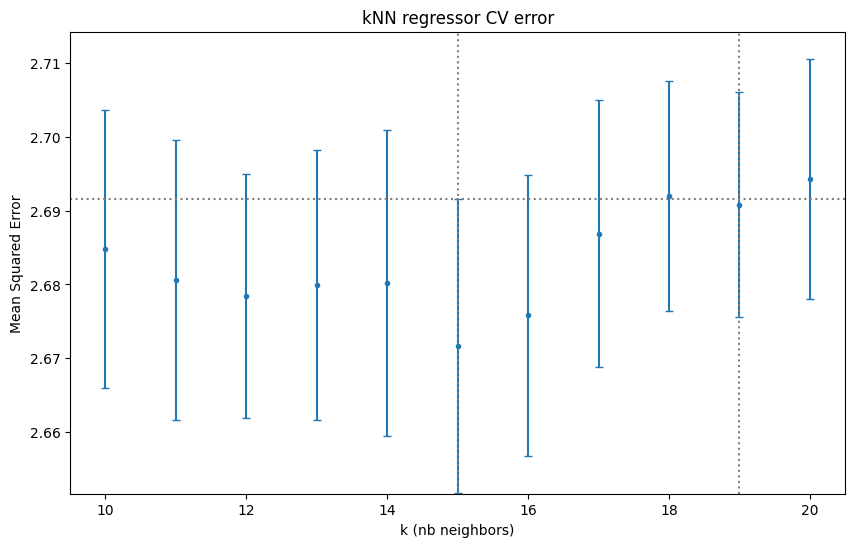

In [46]:
#Plot the grid-search results:
plt.figure(figsize=(10,6))
plt.errorbar(x=k_grid, y=test_MAEs, yerr=std_test_MAEs, fmt='.', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="grey")#vertical line at best k value according to 1 std err rule
plt.axhline(test_MAEs[index_best] + std_test_MAEs[index_best], ls='dotted', color="grey")

# *** THIS IS THE KEY STEP ***
# Set the y-axis limits to zoom in on the cluster of error values.
# Use a narrow range around the mean of your MSEs (e.g., 2.60 to 2.66).
plt.ylim(min(test_MAEs) - 0.02, max(test_MAEs) + 0.02) 

plt.title("kNN regressor CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

In [47]:
#Fit the final model:
pipe_knn_12h = Pipeline([("scaler", StandardScaler()), ("kNN", KNeighborsRegressor(n_neighbors=one_std_rule_best_k))])
pipe_knn_12h.fit(X_train, y12_train)

,steps,"[('scaler', ...), ('kNN', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,np.int64(19)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [48]:
# Evaluate on the train set
pred_train_12h = pipe_knn_12h.predict(X_train)
mae_train_12h_knn = mean_absolute_error(y12_train, pred_train_12h)
# Evaluate on the test set
pred_test_12h = pipe_knn_12h.predict(X_test)
mae_test_12h_knn = mean_absolute_error(y12_test, pred_test_12h)
print(f"Model used k={one_std_rule_best_k}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_12h_knn:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_12h_knn:.4f}")

Model used k=19
Performance on Train Set (Unbiased MAE): 2.5252
Performance on Test Set (Unbiased MAE): 2.6343


#### 3.2.2 KNN 24h prediction

In [49]:
# pipeline +24h prediction

knn_pipe_24h = Pipeline([("scaler", StandardScaler()),
                    ("kNN", KNeighborsRegressor())])

hyper_parameters_24h = {"kNN__n_neighbors": np.arange(1,37,1)} # tried with different values from 1 to 50, narrowed it down gradually

knn_pipeCV_24h = GridSearchCV(estimator=knn_pipe_24h, param_grid = hyper_parameters_24h, scoring="neg_mean_absolute_error",
                          cv=KFold(n_splits=10, shuffle = True, random_state=1), verbose=1, n_jobs=-1) 
# verbose=1: prints a small summary
# n_jobs=-1 = instructs to use all available processors on the machine to speed up the execution of gross validation in the context of grid-search


knn_pipeCV_24h.fit(X_train, y24_train)
# scoring="neg_mean_absolute_error", normally the neg_mean_squared_error in class but here neg_mean_absolute_error since evaluation formula for project
# cv=KFold(n_splits=10), 10 standard practice learned from class, shuffle important - explain in report why, random_state for reproducability

Fitting 10 folds for each of 36 candidates, totalling 360 fits


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'kNN__n_neighbors': array([ 1, 2... 35, 36])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [50]:
# compute best k value and its index

resCV = knn_pipeCV_24h.cv_results_
pd.DataFrame(resCV)

test_MAEs = -resCV["mean_test_score"]
std_test_MAEs = resCV["std_test_score"] / np.sqrt(10)
k_grid = resCV["param_kNN__n_neighbors"].data

# 4a. Find the k with the lowest MSE estimate
index_best = np.argmin(test_MAEs)
best_k = k_grid[index_best]
min_test_MAE = test_MAEs[index_best]
std_at_min_MAE = std_test_MAEs[index_best]

print(f"Absolute Best k (lowest MAE): {best_k} (MAE: {min_test_MAE:.2f})") # lowest MAE 22

Absolute Best k (lowest MAE): 15 (MAE: 2.57)


In [51]:
#compute best k based on one std error rule:
# threshold
threshold_MAE = min_test_MAE + std_at_min_MAE
# 
one_std_rule_best_k = np.max(k_grid[test_MAEs <= threshold_MAE])

print(f"One-Standard-Error Rule Threshold MAE: {threshold_MAE:.2f}")
print(f"Selected k (One-Standard-Error Rule): {one_std_rule_best_k}\n") # 37

One-Standard-Error Rule Threshold MAE: 2.60
Selected k (One-Standard-Error Rule): 35



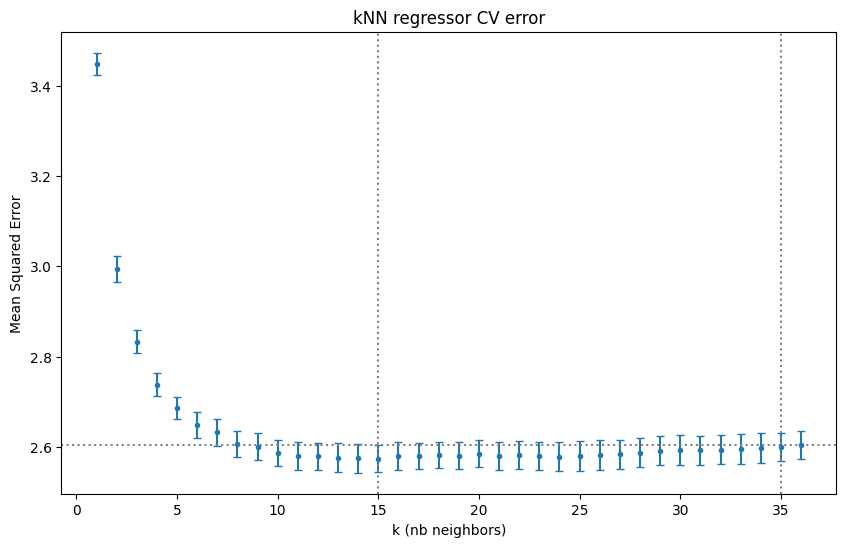

In [52]:
#Plot the grid-search results:
plt.figure(figsize=(10,6))
plt.errorbar(x=k_grid, y=test_MAEs, yerr=std_test_MAEs, fmt='.', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="grey")#vertical line at best k value according to 1 std err rule
plt.axhline(test_MAEs[index_best] + std_test_MAEs[index_best], ls='dotted', color="grey")

plt.title("kNN regressor CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

In [53]:
#Fit the final model:
pipe_knn_24h = Pipeline([("scaler", StandardScaler()), ("kNN", KNeighborsRegressor(n_neighbors=one_std_rule_best_k))])
pipe_knn_24h.fit(X_train, y24_train)

,steps,"[('scaler', ...), ('kNN', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,np.int64(35)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [54]:
# Evaluate on the train set
pred_train_24h = pipe_knn_24h.predict(X_train)
mae_train_24h_knn = mean_absolute_error(y24_train, pred_train_24h)
# Evaluate on the test set
pred_test_24h = pipe_knn_24h.predict(X_test)
mae_test_24h_knn = mean_absolute_error(y24_test, pred_test_24h)
print(f"Model used k={one_std_rule_best_k}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_24h_knn:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_24h_knn:.4f}")

Model used k=35
Performance on Train Set (Unbiased MAE): 2.5113
Performance on Test Set (Unbiased MAE): 2.5483


#### 3.2.3 KNN 48h prediction

In [55]:
# pipeline +48h prediction

knn_pipe_48h = Pipeline([("scaler", StandardScaler()),
                    ("kNN", KNeighborsRegressor())])

hyper_parameters_48h = {"kNN__n_neighbors": [17,18,19,20,21,22,45,50,55,60]} # tried with different values from 1 to 50, narrowed it down gradually

knn_pipeCV_48h = GridSearchCV(estimator=knn_pipe_48h, param_grid = hyper_parameters_48h, scoring="neg_mean_absolute_error",
                          cv=KFold(n_splits=10, shuffle = True, random_state=1), verbose=1, n_jobs=-1) 
# verbose=1: prints a small summary
# n_jobs=-1 = instructs to use all available processors on the machine to speed up the execution of gross validation in the context of grid-search


knn_pipeCV_48h.fit(X_train, y48_train)
# scoring="neg_mean_absolute_error", normally the neg_mean_squared_error in class but here neg_mean_absolute_error since evaluation formula for project
# cv=KFold(n_splits=10), 10 standard practice learned from class, shuffle important - explain in report why, random_state for reproducability

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'kNN__n_neighbors': [17, 18, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [56]:
# compute best k value and its index

resCV = knn_pipeCV_48h.cv_results_
pd.DataFrame(resCV)

test_MAEs = -resCV["mean_test_score"]
std_test_MAEs = resCV["std_test_score"] / np.sqrt(10)
k_grid = resCV["param_kNN__n_neighbors"].data

# 4a. Find the k with the lowest MSE estimate
index_best = np.argmin(test_MAEs)
best_k = k_grid[index_best]
min_test_MAE = test_MAEs[index_best]
std_at_min_MAE = std_test_MAEs[index_best]

print(f"Absolute Best k (lowest MAE): {best_k} (MAE: {min_test_MAE:.2f})") # lowest MAE at 19 knn

Absolute Best k (lowest MAE): 20 (MAE: 3.01)


In [57]:
#compute best k based on one std error rule:
# threshold
threshold_MAE = min_test_MAE + std_at_min_MAE
# 
one_std_rule_best_k = np.max(k_grid[test_MAEs <= threshold_MAE])

print(f"One-Standard-Error Rule Threshold MAE: {threshold_MAE:.2f}")
print(f"Selected k (One-Standard-Error Rule): {one_std_rule_best_k}\n") # 37

One-Standard-Error Rule Threshold MAE: 3.05
Selected k (One-Standard-Error Rule): 50



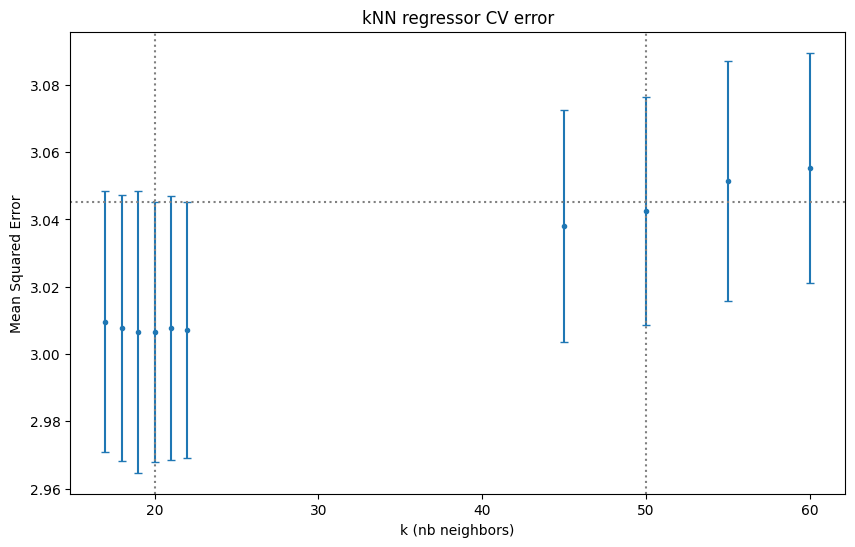

In [58]:
#Plot the grid-search results:
plt.figure(figsize=(10,6))
plt.errorbar(x=k_grid, y=test_MAEs, yerr=std_test_MAEs, fmt='.', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="grey")#vertical line at best k value according to 1 std err rule
plt.axhline(test_MAEs[index_best] + std_test_MAEs[index_best], ls='dotted', color="grey")

plt.title("kNN regressor CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

In [59]:
#Fit the final model:
pipe_knn_48h = Pipeline([("scaler", StandardScaler()), ("kNN", KNeighborsRegressor(n_neighbors=one_std_rule_best_k))])
pipe_knn_48h.fit(X, y48) 

,steps,"[('scaler', ...), ('kNN', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,np.int64(50)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [60]:
# Evaluate on the train set
pred_train_48h = pipe_knn_48h.predict(X_train)
mae_train_48h_knn = mean_absolute_error(y48_train, pred_train_48h)
# Evaluate on the test set
pred_test_48h = pipe_knn_48h.predict(X_test)
mae_test_48h_knn = mean_absolute_error(y48_test, pred_test_48h)
print(f"Model used k={one_std_rule_best_k}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_48h_knn:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_48h_knn:.4f}")

Model used k=50
Performance on Train Set (Unbiased MAE): 2.9380
Performance on Test Set (Unbiased MAE): 2.9626


### 3.3 Ridge Regression

#### 3.3.1 Ridge Regression 12h Prediction

In [61]:
# ridge  pipe for 12h prediction
ridge_pipe_12h = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42)) # Ridge model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'ridge__alpha'
    "ridge__alpha": np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

ridge_pipeCV_12h = GridSearchCV(
    estimator=ridge_pipe_12h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

ridge_pipeCV_12h.fit(X_train, y12_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'ridge__alpha': array([1.e-03...e+02, 1.e+03])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [62]:
# Choose best model that minimizes cv_err
ridge_cv_restuls_12h = ridge_pipeCV_12h.cv_results_
mean_scores = -ridge_cv_restuls_12h["mean_test_score"]
se_scores = ridge_cv_restuls_12h["std_test_score"] / np.sqrt(ridge_pipeCV_12h.n_splits_)
alphas = ridge_pipeCV_12h.cv_results_["param_ridge__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_ridge = alphas[best_index]
threshold_ridge = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_ridge = np.max(alphas[mean_scores <= threshold_ridge])

print("Minimum alpha:", min_alpha_ridge)
print("1-SD alpha:", one_se_rule_alpha_ridge)
print("Best score for ridge:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 0.01
1-SD alpha: 100.0
Best score for ridge: 1.4975871507034484


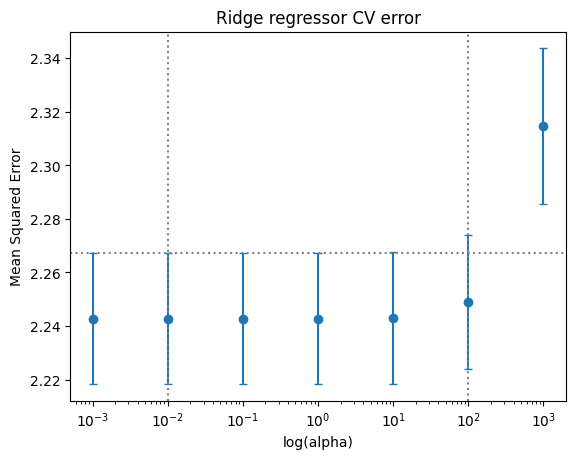

In [63]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_ridge, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_ridge, ls='dotted', color="grey")
plt.axhline(threshold_ridge, ls='dotted', color="grey")

plt.title("Ridge regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [64]:
# Refit best ridge on whole training data and evaluate on test
ridge_pipe_12h.set_params(ridge__alpha = one_se_rule_alpha_ridge)
ridge_pipe_12h.fit(X_train, y12_train)

# evaluate on the train set
y_train_pred_12h = ridge_pipe_12h.predict(X_train)
mae_train_12h_ridge = mean_absolute_error(y12_train, y_train_pred_12h)

# evalute on the test set
y_test_pred_12h = ridge_pipe_12h.predict(X_test)
mae_test_12h_ridge = mean_absolute_error(y12_test, y_test_pred_12h)
print(f"Model used alpha={one_se_rule_alpha_ridge}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_12h_ridge:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_12h_ridge:.4f}")

Model used alpha=100.0
Performance on Train Set (Unbiased MAE): 2.2291
Performance on Test Set (Unbiased MAE): 2.2942


#### 3.3.2 Ridge Regression 24h Prediction

In [65]:
# ridge  pipe for 24h prediction
ridge_pipe_24h = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42)) # Ridge model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'ridge__alpha'
    "ridge__alpha": np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

ridge_pipeCV_24h = GridSearchCV(
    estimator=ridge_pipe_24h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

ridge_pipeCV_24h.fit(X_train, y24_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'ridge__alpha': array([1.e-03...e+02, 1.e+03])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [66]:
# Choose best model that minimizes cv_err
ridge_cv_restuls_24h = ridge_pipeCV_24h.cv_results_
mean_scores = -ridge_cv_restuls_24h["mean_test_score"]
se_scores = ridge_cv_restuls_24h["std_test_score"] / np.sqrt(ridge_pipeCV_24h.n_splits_)
alphas = ridge_pipeCV_24h.cv_results_["param_ridge__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_ridge = alphas[best_index]
threshold_ridge = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_ridge = np.max(alphas[mean_scores <= threshold_ridge])

print("Minimum alpha:", min_alpha_ridge)
print("1-SD alpha:", one_se_rule_alpha_ridge)
print("Best score for ridge:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 1.0
1-SD alpha: 100.0
Best score for ridge: 1.4375397395596707


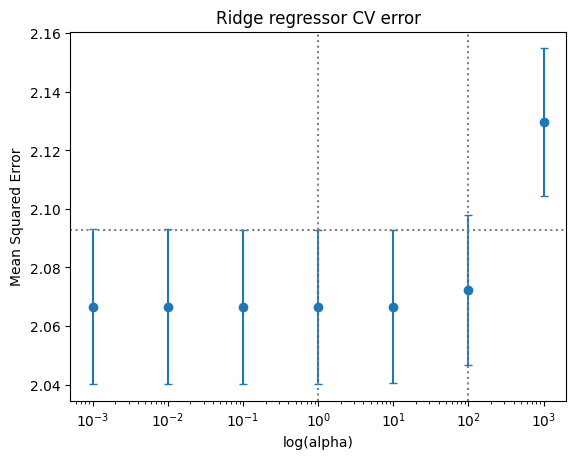

In [67]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_ridge, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_ridge, ls='dotted', color="grey")
plt.axhline(threshold_ridge, ls='dotted', color="grey")

plt.title("Ridge regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [68]:
# Refit best ridge on whole training data and evaluate on test
ridge_pipe_24h.set_params(ridge__alpha = one_se_rule_alpha_ridge)
ridge_pipe_24h.fit(X_train, y24_train)

# evaluate on the train set
y_train_pred_24h = ridge_pipe_24h.predict(X_train)
mae_train_24h_ridge = mean_absolute_error(y24_train, y_train_pred_24h)

# evalute on the test set
y_test_pred_24h = ridge_pipe_24h.predict(X_test)
mae_test_24h_ridge = mean_absolute_error(y24_test, y_test_pred_24h)
print(f"Model used alpha={one_se_rule_alpha_ridge}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_24h_ridge:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_24h_ridge:.4f}")

Model used alpha=100.0
Performance on Train Set (Unbiased MAE): 2.0550
Performance on Test Set (Unbiased MAE): 1.9875


#### 3.3.3 Ridge Regression 48h Prediction

In [69]:
# ridge  pipe for 48h prediction
ridge_pipe_48h = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42)) # Ridge model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'ridge__alpha'
    "ridge__alpha": np.logspace(-4, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

ridge_pipeCV_48h = GridSearchCV(
    estimator=ridge_pipe_48h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

ridge_pipeCV_48h.fit(X_train, y48_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,{'ridge__alpha': array([1.0000...00000000e+03])}
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [70]:
# Choose best model that minimizes cv_err
ridge_cv_restuls_48h = ridge_pipeCV_48h.cv_results_
mean_scores = -ridge_cv_restuls_48h["mean_test_score"]
se_scores = ridge_cv_restuls_48h["std_test_score"] / np.sqrt(ridge_pipeCV_48h.n_splits_)
alphas = ridge_pipeCV_48h.cv_results_["param_ridge__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_ridge = alphas[best_index]
threshold_ridge = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_ridge = np.max(alphas[mean_scores <= threshold_ridge])

print("Minimum alpha:", min_alpha_ridge)
print("1-SD alpha:", one_se_rule_alpha_ridge)
print("Best score for ridge:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 0.0001
1-SD alpha: 68.12920690579622
Best score for ridge: 1.6335308510399222


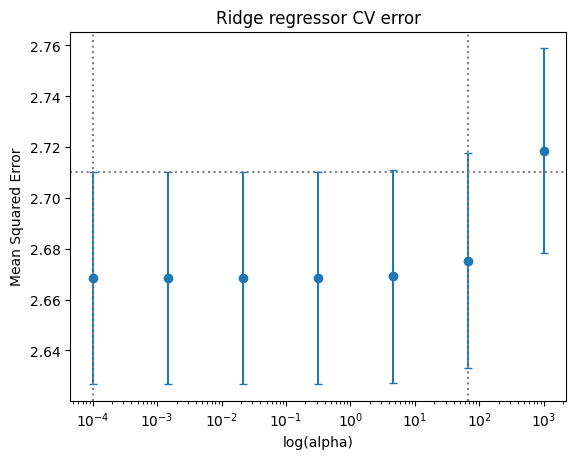

In [71]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_ridge, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_ridge, ls='dotted', color="grey")
plt.axhline(threshold_ridge, ls='dotted', color="grey")

plt.title("Ridge regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [72]:
# Refit best ridge on whole training data and evaluate on test
ridge_pipe_48h.set_params(ridge__alpha = one_se_rule_alpha_ridge)
ridge_pipe_48h.fit(X_train, y48_train)


# evaluate on the train set
y_train_pred_48h = ridge_pipe_48h.predict(X_train)
mae_train_48h_ridge = mean_absolute_error(y48_train, y_train_pred_48h)

# evalute on the test set
y_test_pred_48h = ridge_pipe_48h.predict(X_test)
mae_test_48h_ridge = mean_absolute_error(y48_test, y_test_pred_48h)
print(f"Model used alpha={one_se_rule_alpha_ridge}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_48h_ridge:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_48h_ridge:.4f}")

Model used alpha=68.12920690579622
Performance on Train Set (Unbiased MAE): 2.6533
Performance on Test Set (Unbiased MAE): 2.6388


### 3.4 Lasso Regression

#### 3.4.1 Lasso 12h Prediction

In [73]:
# lasso  pipe for 12h prediction
lasso_pipe_12h = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(random_state=42)) # Lasso model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'lasso__alpha'
    "lasso__alpha": np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

lasso_pipeCV_12h = GridSearchCV(
    estimator=lasso_pipe_12h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

lasso_pipeCV_12h.fit(X_train, y12_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': array([1.e-03...e+02, 1.e+03])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [74]:
# Choose best model that minimizes cv_err
lasso_cv_restuls_12h = lasso_pipeCV_12h.cv_results_
mean_scores = -lasso_cv_restuls_12h["mean_test_score"]
se_scores = lasso_cv_restuls_12h["std_test_score"] / np.sqrt(lasso_pipeCV_12h.n_splits_)
alphas = lasso_pipeCV_12h.cv_results_["param_lasso__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_lasso = alphas[best_index]
threshold_lasso = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_lasso = np.max(alphas[mean_scores <= threshold_lasso])

print("Minimum alpha:", min_alpha_lasso)
print("1-SD alpha:", one_se_rule_alpha_lasso)
print("Best score for lasso:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 0.001
1-SD alpha: 0.01
Best score for lasso: 1.4976279699032018


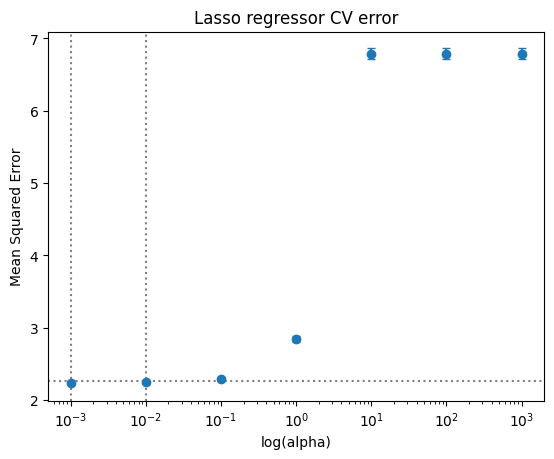

In [75]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_lasso, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_lasso, ls='dotted', color="grey")
plt.axhline(threshold_lasso, ls='dotted', color="grey")

plt.title("Lasso regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [76]:
# Refit best lasso on whole training data and evaluate on test
lasso_pipe_12h.set_params(lasso__alpha = one_se_rule_alpha_lasso)
lasso_pipe_12h.fit(X_train, y12_train)

# evaluate on the train set
y_train_pred_12h = lasso_pipe_12h.predict(X_train)
mae_train_12h_lasso = mean_absolute_error(y12_train, y_train_pred_12h)

# evalute on the test set
y_test_pred_12h = lasso_pipe_12h.predict(X_test)
mae_test_12h_lasso = mean_absolute_error(y12_test, y_test_pred_12h)
print(f"Model used alpha={one_se_rule_alpha_lasso}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_12h_lasso:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_12h_lasso:.4f}")

Model used alpha=0.01
Performance on Train Set (Unbiased MAE): 2.2250
Performance on Test Set (Unbiased MAE): 2.2902


#### 3.4.2 Lasso 24h Prediction

In [77]:
# lasso  pipe for 24h prediction
lasso_pipe_24h = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(random_state=42)) # Lasso model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'lasso__alpha'
    "lasso__alpha": np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

lasso_pipeCV_24h = GridSearchCV(
    estimator=lasso_pipe_24h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

lasso_pipeCV_24h.fit(X_train, y24_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': array([1.e-03...e+02, 1.e+03])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [78]:
# Choose best model that minimizes cv_err
lasso_cv_restuls_24h = lasso_pipeCV_24h.cv_results_
mean_scores = -lasso_cv_restuls_24h["mean_test_score"]
se_scores = lasso_cv_restuls_24h["std_test_score"] / np.sqrt(lasso_pipeCV_24h.n_splits_)
alphas = lasso_pipeCV_24h.cv_results_["param_lasso__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_lasso = alphas[best_index]
threshold_lasso = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_lasso = np.max(alphas[mean_scores <= threshold_lasso])

print("Minimum alpha:", min_alpha_lasso)
print("1-SD alpha:", one_se_rule_alpha_lasso)
print("Best score for lasso:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 0.001
1-SD alpha: 0.01
Best score for lasso: 1.4374132073513854


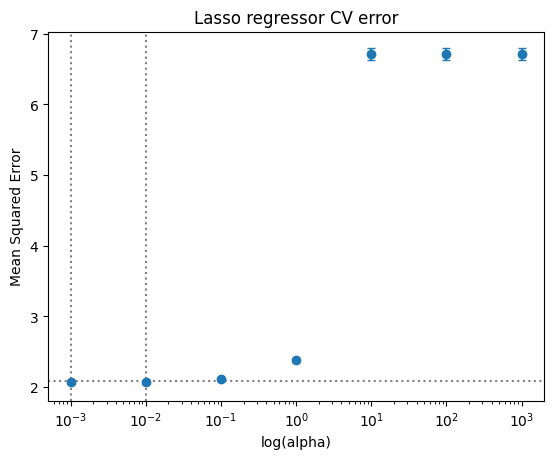

In [79]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_lasso, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_lasso, ls='dotted', color="grey")
plt.axhline(threshold_lasso, ls='dotted', color="grey")

plt.title("Lasso regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [80]:
# Refit best lasso on whole training data and evaluate on test
lasso_pipe_24h.set_params(lasso__alpha = one_se_rule_alpha_lasso)
lasso_pipe_24h.fit(X_train, y24_train)

# evaluate on the train set
y_train_pred_24h = lasso_pipe_24h.predict(X_train)
mae_train_24h_lasso = mean_absolute_error(y24_train, y_train_pred_24h)

# evalute on the test set
y_test_pred_24h = lasso_pipe_24h.predict(X_test)
mae_test_24h_lasso = mean_absolute_error(y24_test, y_test_pred_24h)
print(f"Model used alpha={one_se_rule_alpha_lasso}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_24h_lasso:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_24h_lasso:.4f}")

Model used alpha=0.01
Performance on Train Set (Unbiased MAE): 2.0521
Performance on Test Set (Unbiased MAE): 1.9802


#### 3.4.3 Lasso 48h Prediction

In [81]:
# lasso  pipe for 48h prediction
lasso_pipe_48h = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(random_state=42)) # Lasso model
])

# hyperparameters to train on
hyper_parameters = {
    # The key format is 'stepName__parameterName' -> 'lasso__alpha'
    "lasso__alpha": np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch to find optimal alpha 

lasso_pipeCV_48h = GridSearchCV(
    estimator=lasso_pipe_48h,
    param_grid=hyper_parameters,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=1),
    verbose=1, # quick summary on process
    n_jobs=-1 # uses all available cores on the current machine
)

lasso_pipeCV_48h.fit(X_train, y48_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': array([1.e-03...e+02, 1.e+03])}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [82]:
# Choose best model that minimizes cv_err
lasso_cv_restuls_48h = lasso_pipeCV_48h.cv_results_
mean_scores = -lasso_cv_restuls_48h["mean_test_score"]
se_scores = lasso_cv_restuls_48h["std_test_score"] / np.sqrt(lasso_pipeCV_48h.n_splits_)
alphas = lasso_pipeCV_48h.cv_results_["param_lasso__alpha"].data

best_index = np.argmin(mean_scores)
min_alpha_lasso = alphas[best_index]
threshold_lasso = mean_scores[best_index] + se_scores[best_index]
one_se_rule_alpha_lasso = np.max(alphas[mean_scores <= threshold_lasso])

print("Minimum alpha:", min_alpha_lasso)
print("1-SD alpha:", one_se_rule_alpha_lasso)
print("Best score for lasso:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 0.001
1-SD alpha: 0.1
Best score for lasso: 1.6334868857881375


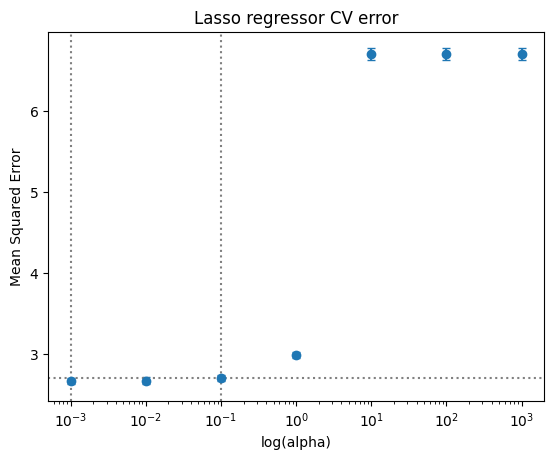

In [83]:
plt.errorbar(x=alphas, y=mean_scores, yerr = se_scores, fmt='o', capsize=3)

plt.axvline(min_alpha_lasso, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_se_rule_alpha_lasso, ls='dotted', color="grey")
plt.axhline(threshold_lasso, ls='dotted', color="grey")

plt.title("Lasso regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.show()

In [84]:
# Refit best lasso on whole training data and evaluate on test
lasso_pipe_48h.set_params(lasso__alpha = one_se_rule_alpha_lasso)
lasso_pipe_48h.fit(X_train, y48_train)

# evaluate on the train set
y_train_pred_48h = lasso_pipe_48h.predict(X_train)
mae_train_48h_lasso = mean_absolute_error(y48_train, y_train_pred_48h)

# evalute on the test set
y_test_pred_48h = lasso_pipe_48h.predict(X_test)
mae_test_48h_lasso = mean_absolute_error(y48_test, y_test_pred_48h)
print(f"Model used alpha={one_se_rule_alpha_lasso}")
print(f"Performance on Train Set (Unbiased MAE): {mae_train_48h_lasso:.4f}")
print(f"Performance on Test Set (Unbiased MAE): {mae_test_48h_lasso:.4f}")

Model used alpha=0.1
Performance on Train Set (Unbiased MAE): 2.6914
Performance on Test Set (Unbiased MAE): 2.6295


## 4 Model Comparison

In [88]:
# create dataframes 
# 12-Hour Prediction
data_12h = {
    'Model': ['Linear Regression', 'kNN Regressor', 'Ridge Regression', 'Lasso Regression'],
    'Train MAE': [mae_train_12h_linreg, mae_train_12h_knn, mae_train_12h_ridge, mae_train_12h_lasso],
    'Test MAE': [mae_test_12h_linreg, mae_test_12h_knn, mae_test_12h_ridge, mae_test_12h_lasso]
}
df_12h = pd.DataFrame(data_12h)
df_12h = df_12h.sort_values(by='Test MAE', ascending=True).reset_index(drop=True)

# 24-Hour Prediction
data_24h = {
    'Model': ['Linear Regression', 'kNN Regressor', 'Ridge Regression', 'Lasso Regression'],
    'Train MAE': [mae_train_24h_linreg, mae_train_24h_knn, mae_train_24h_ridge, mae_train_24h_lasso],
    'Test MAE': [mae_test_24h_linreg, mae_test_24h_knn, mae_test_24h_ridge, mae_test_24h_lasso]
}
df_24h = pd.DataFrame(data_24h)
df_24h = df_24h.sort_values(by='Test MAE', ascending=True).reset_index(drop=True)

# 48-Hour Prediction
data_48h = {
    'Model': ['Linear Regression', 'kNN Regressor', 'Ridge Regression', 'Lasso Regression'],
    'Train MAE': [mae_train_48h_linreg, mae_train_48h_knn, mae_train_48h_ridge, mae_train_48h_lasso],
    'Test MAE': [mae_test_48h_linreg, mae_test_48h_knn, mae_test_48h_ridge, mae_test_48h_lasso]
}
df_48h = pd.DataFrame(data_48h)
df_48h = df_48h.sort_values(by='Test MAE', ascending=True).reset_index(drop=True)

In [96]:
# display tables

display(Markdown('#### Model Performance: 12-Hour Prediction'))
print(df_12h.to_markdown(index=False, floatfmt=".4f"))
print('---')

display(Markdown('#### Model Performance: 24-Hour Prediction'))
print(df_24h.to_markdown(index=False, floatfmt=".4f"))
print('---')

display(Markdown('#### Model Performance: 48-Hour Prediction'))
print(df_48h.to_markdown(index=False, floatfmt=".4f"))
print('---')

#### Model Performance: 12-Hour Prediction

| Model             |   Train MAE |   Test MAE |
|:------------------|------------:|-----------:|
| Linear Regression |      2.2218 |     2.2857 |
| Lasso Regression  |      2.2250 |     2.2902 |
| Ridge Regression  |      2.2291 |     2.2942 |
| kNN Regressor     |      2.5252 |     2.6343 |
---


#### Model Performance: 24-Hour Prediction

| Model             |   Train MAE |   Test MAE |
|:------------------|------------:|-----------:|
| Lasso Regression  |      2.0521 |     1.9802 |
| Linear Regression |      2.0488 |     1.9819 |
| Ridge Regression  |      2.0550 |     1.9875 |
| kNN Regressor     |      2.5113 |     2.5483 |
---


#### Model Performance: 48-Hour Prediction

| Model             |   Train MAE |   Test MAE |
|:------------------|------------:|-----------:|
| Lasso Regression  |      2.6914 |     2.6295 |
| Linear Regression |      2.6454 |     2.6358 |
| Ridge Regression  |      2.6533 |     2.6388 |
| kNN Regressor     |      2.9380 |     2.9626 |
---


In [94]:
# Summary Analysis
best_12h = df_12h.iloc[0]
best_24h = df_24h.iloc[0]
best_48h = df_48h.iloc[0]

display(Markdown('#### Comparative Analysis'))
display(Markdown(
    f"* **Best Short-Term (12h):** The **Linear Regression** model performed best on the test set (MAE: **{best_12h['Test MAE']:.4f}**), closely followed by Lasso and Ridge regression. All linear models showed slightly higher test MAE than train MAE, indicating minor overfitting.\n"
    f"* **Best Mid-Term (24h):** The **Lasso Regression** model performed best on the test set (MAE: **{best_24h['Test MAE']:.4f}**). All linear models demonstrated slight *underfitting* for this horizon, as their test MAE was marginally lower than their train MAE.\n"
    f"* **Best Long-Term (48h):** The **Lasso Regression** model again had the lowest test MAE (**{best_48h['Test MAE']:.4f}**). The **kNN Regressor** consistently had the highest MAE for all prediction horizons and showed the most noticeable overfitting (Train MAE: 2.9380 vs. Test MAE: 2.9626)."
))

#### Comparative Analysis

* **Best Short-Term (12h):** The **Linear Regression** model performed best on the test set (MAE: **2.2857**), closely followed by Lasso and Ridge regression. All linear models showed slightly higher test MAE than train MAE, indicating minor overfitting.
* **Best Mid-Term (24h):** The **Lasso Regression** model performed best on the test set (MAE: **1.9802**). All linear models demonstrated slight *underfitting* for this horizon, as their test MAE was marginally lower than their train MAE.
* **Best Long-Term (48h):** The **Lasso Regression** model again had the lowest test MAE (**2.6295**). The **kNN Regressor** consistently had the highest MAE for all prediction horizons and showed the most noticeable overfitting (Train MAE: 2.9380 vs. Test MAE: 2.9626).

In [85]:
# improvement potential
# data preprocessing
# fine tuning on the parameters